# Exercise: Introduction to Data Science

## Exercise 1: Understand and analyze the data

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import missingno as ms

%matplotlib inline

Get the gas station information history:
- STID: unique gas station id
- E5: price for one litre Super E5 (in tenth of a cent)
- E10: price for one litre Super E10 (in tenth of a cent)
- DIESEL: price for one litre Super Diesel (in tenth of a cent)
- DATECHANGE: date of this change
- CHANGED: bit mask for the change

In [2]:
price_data = pd.read_csv('example_sprit_cut_prices.csv', sep=';')
price_data.head()

,STID,E5,E10,DIESEL,DATE_CHANGED,CHANGED
0,01bf5a06-4248-43a5-9524-56123fa3ab2f,1589,1549,1389,2014-10-02 05:22:01.000000,21
1,01bf5a06-4248-43a5-9524-56123fa3ab2f,1569,1529,1369,2014-10-02 05:26:01.000000,21
2,01bf5a06-4248-43a5-9524-56123fa3ab2f,1569,1529,1359,2014-10-02 09:06:01.000000,1
3,01bf5a06-4248-43a5-9524-56123fa3ab2f,1539,1499,1339,2014-10-03 12:14:01.000000,21
4,01bf5a06-4248-43a5-9524-56123fa3ab2f,1529,1489,1329,2014-10-03 14:14:01.000000,21


In [3]:
price_data.tail()

,STID,E5,E10,DIESEL,DATE_CHANGED,CHANGED
2189521,f5552423-47e5-4290-bce2-5625bb6c8a69,1329,1309,1169,2015-02-14 13:46:01.000000,21
2189522,f5552423-47e5-4290-bce2-5625bb6c8a69,1429,1409,1259,2015-02-16 05:06:01.000000,21
2189523,f5552423-47e5-4290-bce2-5625bb6c8a69,1389,1369,1219,2015-02-16 07:22:01.000000,21
2189524,f5552423-47e5-4290-bce2-5625bb6c8a69,1369,1349,1239,2015-02-17 07:10:01.000000,21
2189525,f5552423-47e5-4290-bce2-5625bb6c8a69,1369,1349,1219,2015-02-17 08:02:01.000000,1


In [4]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189526 entries, 0 to 2189525
Data columns (total 6 columns):
STID            object
E5              int64
E10             int64
DIESEL          int64
DATE_CHANGED    object
CHANGED         int64
dtypes: int64(4), object(2)
memory usage: 100.2+ MB


It seems that no values are missing.

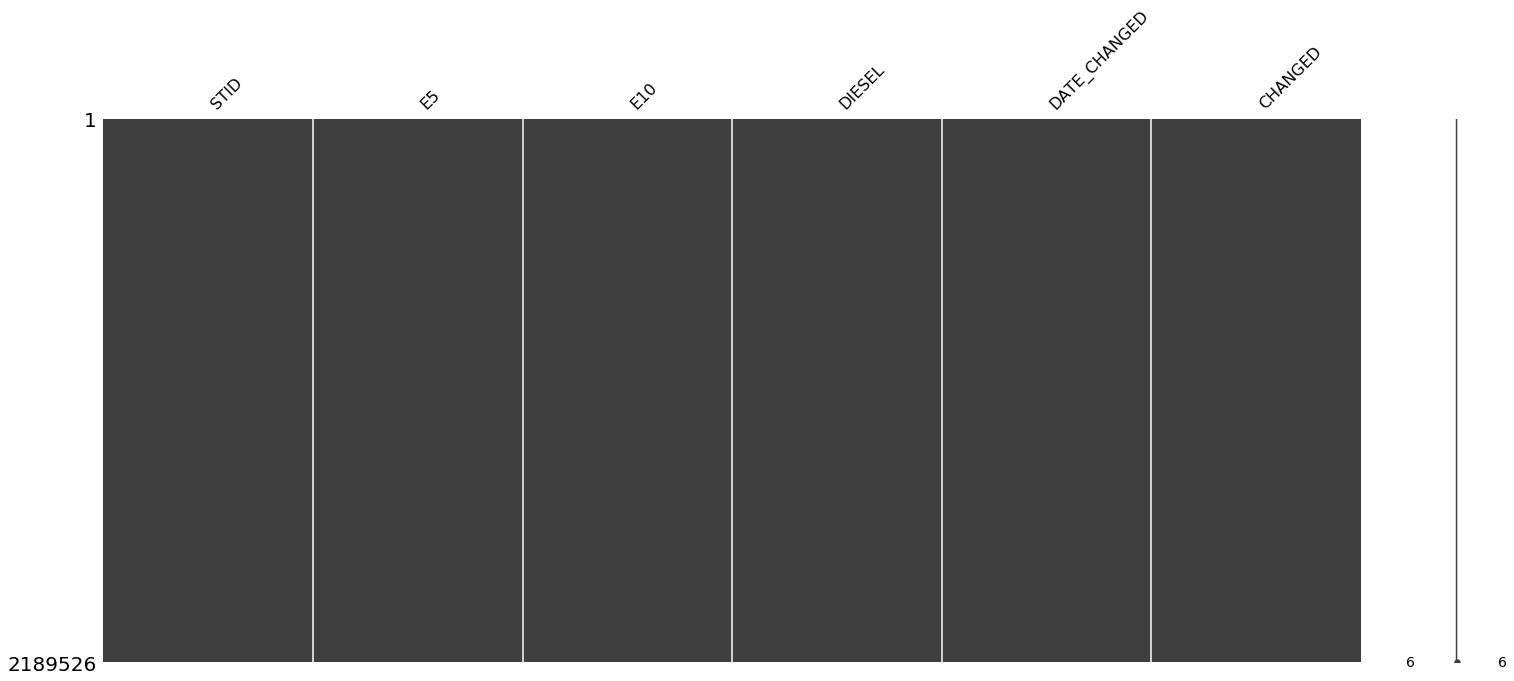

In [5]:
ms.matrix(price_data)

In [6]:
price_data.isnull().values.any()

False

In the history table are only price changes stored . The price at a certain time must therefore be calculated from the last change.
The minimum value for the different types of petrol is -1, which represents an invalid value.

In [7]:
price_data.describe()

,E5,E10,DIESEL,CHANGED
count,2.189526e+06,2.189526e+06,2.189526e+06,2.189526e+06
mean,1.434320e+03,1.404088e+03,1.247491e+03,1.871165e+01
std,2.091502e+02,2.116844e+02,1.037774e+02,8.031150e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00
25%,1.379000e+03,1.349000e+03,1.169000e+03,2.100000e+01
50%,1.459000e+03,1.429000e+03,1.239000e+03,2.100000e+01
75%,1.529000e+03,1.499000e+03,1.324000e+03,2.100000e+01
max,9.999000e+03,9.999000e+03,1.129000e+04,6.300000e+01


First we remove duplicate rows

In [8]:
price_data.drop_duplicates(inplace=True)
price_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1094763 entries, 0 to 2177846
Data columns (total 6 columns):
STID            1094763 non-null object
E5              1094763 non-null int64
E10             1094763 non-null int64
DIESEL          1094763 non-null int64
DATE_CHANGED    1094763 non-null object
CHANGED         1094763 non-null int64
dtypes: int64(4), object(2)
memory usage: 58.5+ MB


Create a function for the price calculation:

Use the bitmask for changes:

|    Bitmask     | Diesel | E5 | E10 |
|---------|--------|----|-----|
| new     | 3      | 12 | 48  |
| removed | 2      | 8  | 32  |
| changed | 1      | 4  | 16  |

In [9]:
# before using this function sort the dataframe by STID and DATE_CHANGED and add a new column with STID values shifted by 1
# unit test at end of file

def calculate_price(df, gasoline_type='diesel'):
    
    # create bitmask for the gasoline_type
    no_change = 0
    if gasoline_type is 'diesel':
        mask = 3
        new = 3
        removed = 2
        changed = 1
        name = 'DIESEL'
    elif gasoline_type is 'e5':
        mask = 12
        new = 12 
        removed = 8
        changed = 4
        name = 'E5'
    elif gasoline_type is 'e10':
        mask = 48
        new = 48
        removed = 32
        changed = 16
        name = 'E10'
    else:
        raise('Unknown gasoline type')
    
    # the first value of a gas station must be new or changed to ensure that the value is valid
    if df['STID'] != df['STID_SHIFT']:
        if int(df['CHANGED']) & mask == no_change and int(df['CHANGED']) & mask == removed:
            return -1
        else:
            return df[name]
        
    # all other values of the gas station
    else:
        # removed: value is invalid
        if int(df['CHANGED']) & mask == removed:
            return -1
        # no_change: value must be determinded from the previous value later
        elif int(df['CHANGED']) & mask == no_change:
            return np.nan
        # new or changed: value is valid
        else:
            return df[name]

Sort the dataframe by STID and DATE_CHANGED and add a new column with STID values shifted by 1

In [10]:
price_data = price_data.sort_values(['STID', 'DATE_CHANGED'])

price_data['STID_SHIFT'] = price_data['STID'].shift()

Calculate the prices.
The function fillna is used to determine the values with no changes from previous values

In [11]:
price_data['DIESEL'] = price_data.apply(calculate_price, gasoline_type='diesel', axis=1).fillna(method='ffill')

price_data['E5'] = price_data.apply(calculate_price, gasoline_type='e5', axis=1).fillna(method='ffill')

price_data['E10'] = price_data.apply(calculate_price, gasoline_type='e10', axis=1).fillna(method='ffill')

We dont't need the STID_SHIFT column anymore

In [12]:
price_data.drop(columns=['STID_SHIFT'], inplace=True)

Replace the invalid values with NaN

In [13]:
price_data = price_data.replace(-1, np.nan)

In [14]:
price_data.describe()

,E5,E10,DIESEL,CHANGED
count,1.077652e+06,1.075765e+06,1.094578e+06,1.094763e+06
mean,1.457096e+03,1.428897e+03,1.247700e+03,1.871165e+01
std,1.060586e+02,1.007316e+02,1.024929e+02,8.031152e+00
min,0.000000e+00,0.000000e+00,9.990000e+02,1.000000e+00
25%,1.379000e+03,1.359000e+03,1.169000e+03,2.100000e+01
50%,1.459000e+03,1.429000e+03,1.239000e+03,2.100000e+01
75%,1.529000e+03,1.499000e+03,1.325000e+03,2.100000e+01
max,9.999000e+03,9.999000e+03,1.129000e+04,6.300000e+01


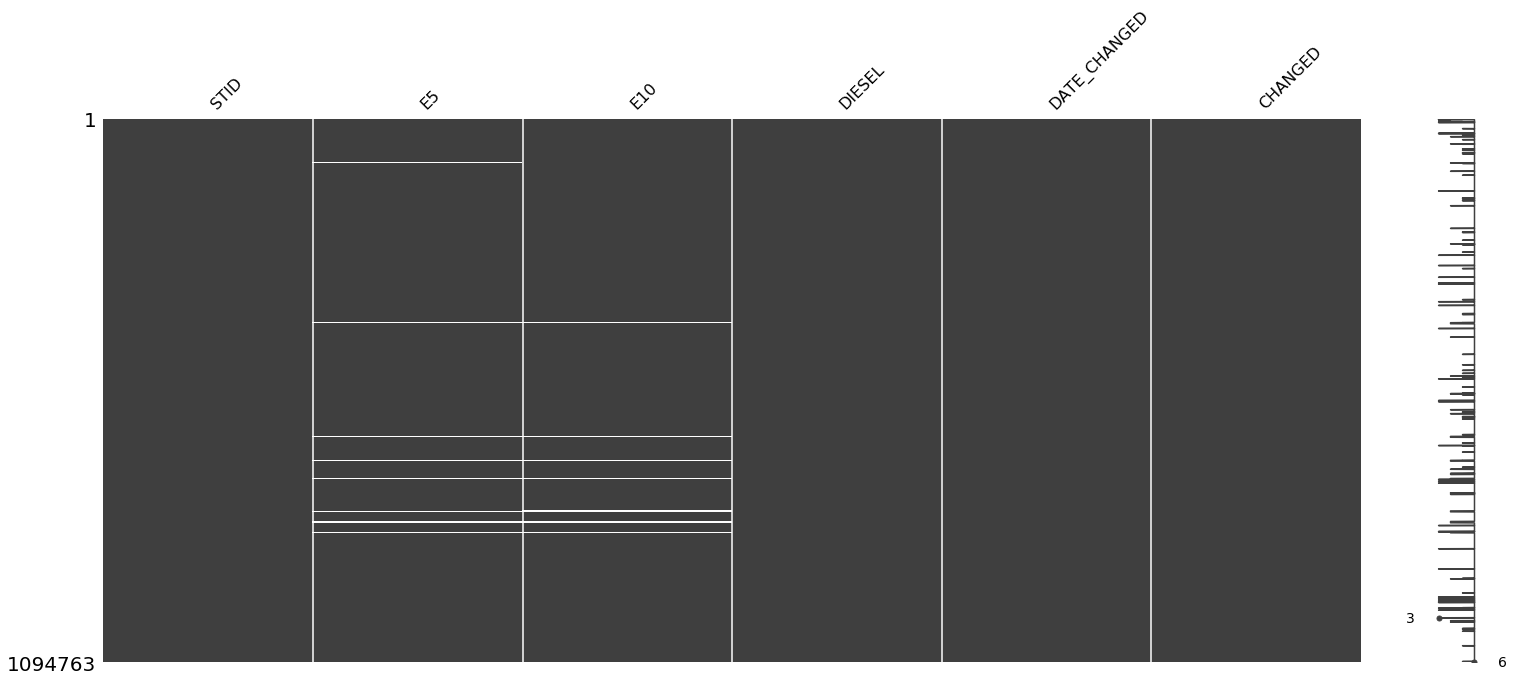

In [15]:
ms.matrix(price_data)

There are some missing values for E5 and E10 and only a few missing values for diesel.

In [16]:
price_data.isna().sum()

STID                0
E5              17111
E10             18998
DIESEL            185
DATE_CHANGED        0
CHANGED             0
dtype: int64

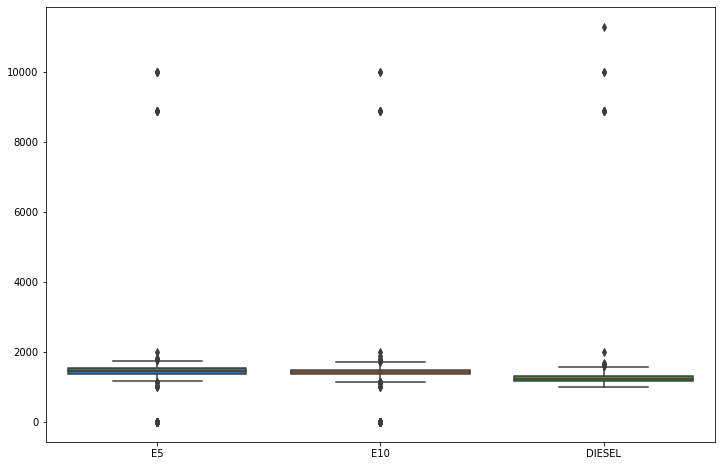

In [17]:
plt.figure(figsize=(12,8))
sns.boxplot(data=price_data[['E5', 'E10', 'DIESEL']])

There are some extreme outliers in the boxplot. These could be price errors or have been transferred incorrectly. A price around 10€ or 0€ doesn't make sense. So we can use the 3x interquartile range to set these values to NaN an keep the medium outliers

In [18]:
q75, q25 = np.percentile(price_data['DIESEL'].dropna(), [75, 25])
IQR = q75 - q25
minimum = q25 - (IQR * 3)
maximum = q75 + (IQR * 3)
price_data['DIESEL'] = price_data['DIESEL'].mask(price_data['DIESEL'] > maximum)
price_data['DIESEL'] = price_data['DIESEL'].mask(price_data['DIESEL'] < minimum)

In [19]:
q75, q25 = np.percentile(price_data['E5'].dropna(), [75, 25])
IQR = q75 - q25
minimum = q25 - (IQR * 3)
maximum = q75 + (IQR * 3)
price_data['E5'] = price_data['E5'].mask(price_data['E5'] > maximum)
price_data['E5'] = price_data['E5'].mask(price_data['E5'] < minimum)

In [20]:
q75, q25 = np.percentile(price_data['E10'].dropna(), [75, 25])
IQR = q75 - q25
minimum = q25 - (IQR * 3)
maximum = q75 + (IQR * 3)
price_data['E10'] = price_data['E10'].mask(price_data['E10'] > maximum)
price_data['E10'] = price_data['E10'].mask(price_data['E10'] < minimum)

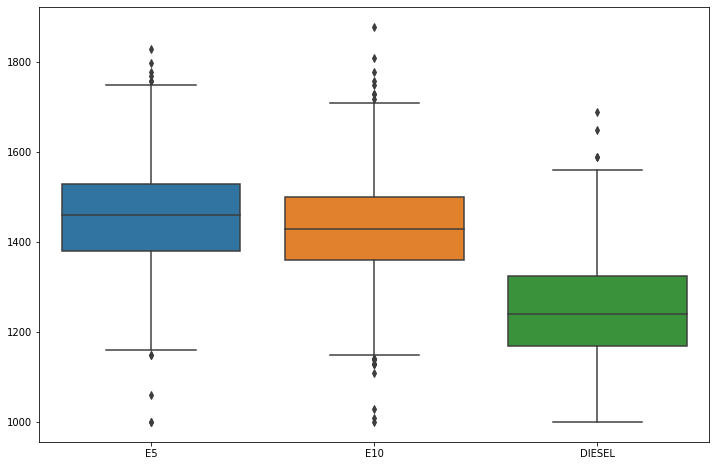

In [21]:
plt.figure(figsize=(12,8))
sns.boxplot(data=price_data[['E5', 'E10', 'DIESEL']])

In [22]:
price_data.dropna(inplace=True)
price_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1075423 entries, 366077 to 915578
Data columns (total 6 columns):
STID            1075423 non-null object
E5              1075423 non-null float64
E10             1075423 non-null float64
DIESEL          1075423 non-null float64
DATE_CHANGED    1075423 non-null object
CHANGED         1075423 non-null int64
dtypes: float64(3), int64(1), object(2)
memory usage: 57.4+ MB


Now our data set looks good and we can begin to analyze it. But first we have a look at the data set of the gas station.

Get the gas station information history:
- ID: unique gas station id
- VERSION: Version number, assigned by the operator
- VERSION_TIME: Information on the last change to the version number, assigned by the operator
- NAME: Name of gas station
- BRAND: Brand of gas station
- STREET: Street of gas station
- HOUSE_NUMBER: House number of gas station
- POST_CODE: Postcode of gas station
- PLACE: Name of the village
- PUBLIC_HOLDIDAY_IDENTIFIER: Abbreviation for state
- LAT: geographical latitude of the location
- LNG: geographical longitude of the location

In [23]:
station_data = pd.read_csv('example_sprit_cut_station.csv', sep=';')
station_data.head()

,ID,VERSION,VERSION_TIME,NAME,BRAND,STREET,HOUSE_NUMBER,POST_CODE,PLACE,PUBLIC_HOLIDAY_IDENTIFIER,LAT,LNG
0,d37bee76-91b6-485a-b974-24f1b0d391fa,4,2015-01-09 10:26:15.000000,Aral Tankstelle,ARAL,An der Tagweide,2,76139,Karlsruhe,\N,49.020280,8.459429
1,51d4b652-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET MANNHEIM UNTERMUEHLAUSTRASSE 83,JET,UNTERMUEHLAUSTRASSE 83,\N,68169,MANNHEIM,\N,49.508962,8.467691
2,c7caf231-0e47-40db-92de-9349a2eb2bef,4,2014-09-26 13:24:57.000000,Aral Tankstelle,ARAL,Trippstadter Straße,69,67663,Kaiserslautern,\N,49.433754,7.757465
3,51d4b53b-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET KAISERSLAUTERN PARISER STR. 167,JET,PARISER STR. 167,\N,67655,KAISERSLAUTERN,\N,49.442200,7.748360
4,51d4b70f-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET GERMERSHEIM MUENCHENER STRASSE 12,JET,MUENCHENER STRASSE 12,\N,76726,GERMERSHEIM,\N,49.226800,8.374400


In [24]:
station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 12 columns):
ID                           824 non-null object
VERSION                      824 non-null int64
VERSION_TIME                 824 non-null object
NAME                         824 non-null object
BRAND                        802 non-null object
STREET                       820 non-null object
HOUSE_NUMBER                 674 non-null object
POST_CODE                    820 non-null object
PLACE                        820 non-null object
PUBLIC_HOLIDAY_IDENTIFIER    824 non-null object
LAT                          824 non-null float64
LNG                          824 non-null float64
dtypes: float64(2), int64(1), object(9)
memory usage: 77.3+ KB


The Version column is not very meaningful, format and use is left to the operator. So we delete the columns Version and Version date. Rename the column ID to STID so that the same name is used for the same data.

In [25]:
station_data.drop(['VERSION', 'VERSION_TIME'], axis=1, inplace=True)
station_data.rename(columns={'ID': 'STID'}, inplace=True)

First we remove duplicate rows and replace the unknown values \N with NaN

In [26]:
station_data.drop_duplicates(inplace=True)
station_data = station_data.replace('\\N', np.nan)
station_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 0 to 709
Data columns (total 10 columns):
STID                         412 non-null object
NAME                         412 non-null object
BRAND                        398 non-null object
STREET                       409 non-null object
HOUSE_NUMBER                 288 non-null object
POST_CODE                    409 non-null object
PLACE                        409 non-null object
PUBLIC_HOLIDAY_IDENTIFIER    54 non-null object
LAT                          412 non-null float64
LNG                          412 non-null float64
dtypes: float64(2), object(8)
memory usage: 35.4+ KB


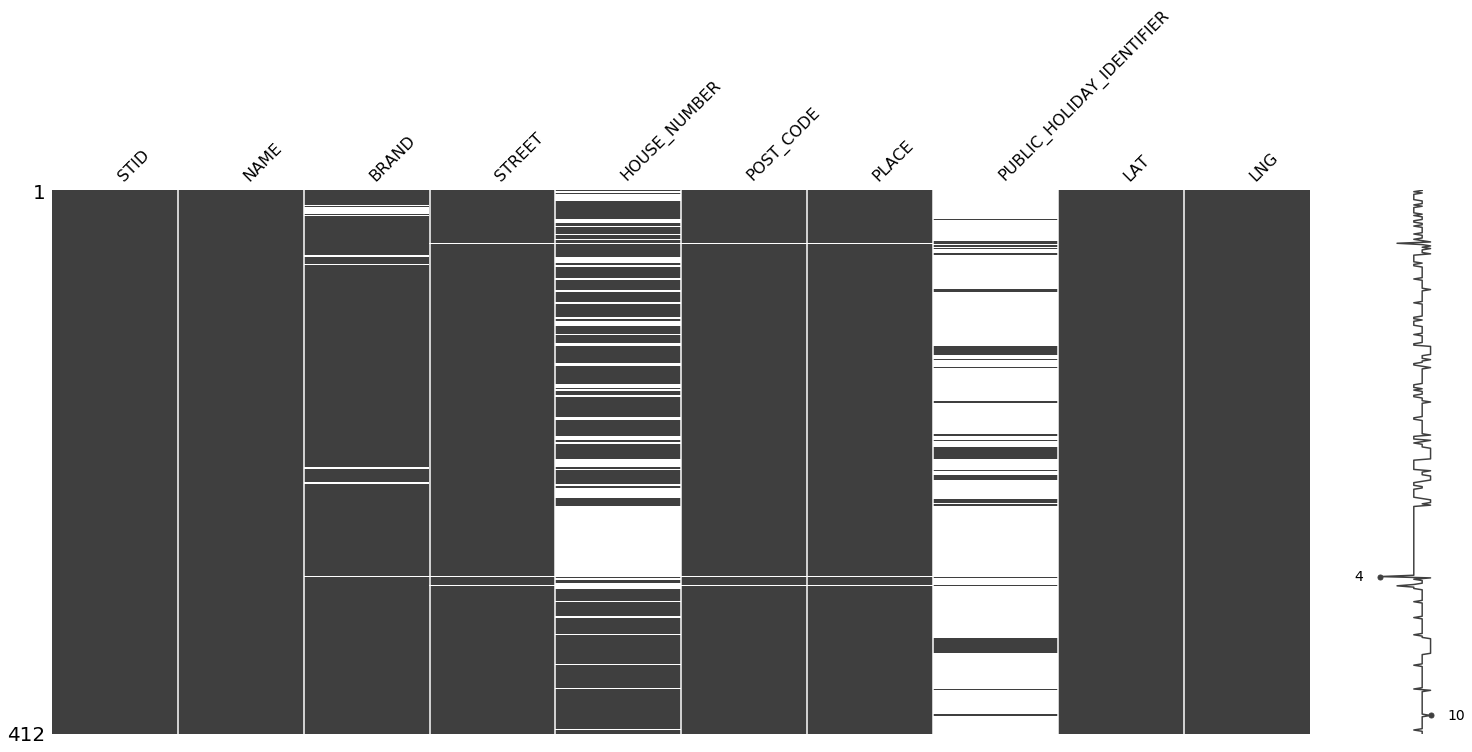

In [27]:
ms.matrix(station_data)

Many location informations and most public holiday identifier are missing. But the values of latitude and longitude are complete. So we can use these information to get the missing values

With geopy we can get location information from latitude and longitude

In [28]:
!pip install geopy
from geopy.geocoders import Nominatim

In [29]:
# This function tries to get postcode, state, road, housenumber and city by latitude and longitude
# unit test at end of file

def get_address(row):
    try:
        # timeout: try maximal 10 times to get an answer from geolocator
        geolocator = Nominatim(user_agent='station_names', timeout=10) 
        location = geolocator.reverse(str(row['LAT']) + ', ' + str(row['LNG']), language='de')
        location = location.raw['address']
        
        if 'postcode' in location:
            row['POST_CODE'] = location['postcode']

        if 'state' in location:
            row['PUBLIC_HOLIDAY_IDENTIFIER'] = location['state']

        if 'road' in location:
            row['STREET'] = location['road']

        if 'house_number' in location:
            row['HOUSE_NUMBER'] = location['house_number']

        if 'village' in location:
            row['PLACE'] = location['village']
        elif 'city' in location:
            row['PLACE'] = location['city']
        elif 'town' in location:
            row['PLACE'] = location['town']

    # there is a limit of 2500 requests per day and sometimes we don't get an answer from the geolocator
    # in order to catch such cases we use this exception
    except Exception as ex:
        message = ("An exception of type {0} occurred ({1}) for " + row['ID']).format(type(ex).__name__, ex.args)
        print(message)        
        return row
              
    return row

In [30]:
station_data = station_data.apply(get_address, axis=1)

In [31]:
station_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 0 to 709
Data columns (total 10 columns):
STID                         412 non-null object
NAME                         412 non-null object
BRAND                        398 non-null object
STREET                       412 non-null object
HOUSE_NUMBER                 355 non-null object
POST_CODE                    412 non-null object
PLACE                        412 non-null object
PUBLIC_HOLIDAY_IDENTIFIER    412 non-null object
LAT                          412 non-null float64
LNG                          412 non-null float64
dtypes: float64(2), object(8)
memory usage: 35.4+ KB


To all stations the street, postcode, town and state for the holiday identifier could be found. Only some brands and housenumbers are sill missing

## Question 1: How many different stations exist in the data set and what is the existing history in days?

First check whether both data sets contain the same STIDs

In [32]:
unique_stids_price = price_data['STID'].unique()
unique_stids_price = np.sort(unique_stids_price)

In [33]:
unique_stids_station = np.sort(station_data['STID'])

In [34]:
np.array_equal(unique_stids_price, unique_stids_station)

False

Get number of unique STIDs. In the data set exist 412 different stations

In [35]:
len(unique_stids_price)

400

Add the date to the data set

In [36]:
price_data['DATE'] = pd.to_datetime(price_data['DATE_CHANGED']).apply(pd.datetime.date)

Group by the STIDs and count the unique dates 

In [37]:
number_of_days = price_data.groupby('STID')['DATE'].nunique()
number_of_days.columns = ['NUMBER OF DAYS']
number_of_days.head()

STID
00060385-0001-4444-8888-acdc00000001    151
00060458-0001-4444-8888-acdc00000001    417
00060562-0001-4444-8888-acdc00000001    304
00060710-0001-4444-8888-acdc00000001    380
00060982-0001-4444-8888-acdcffffffff    400
Name: DATE, dtype: int64

[Text(0, 0.5, 'Number of stations'), Text(0.5, 0, 'Number of days')]

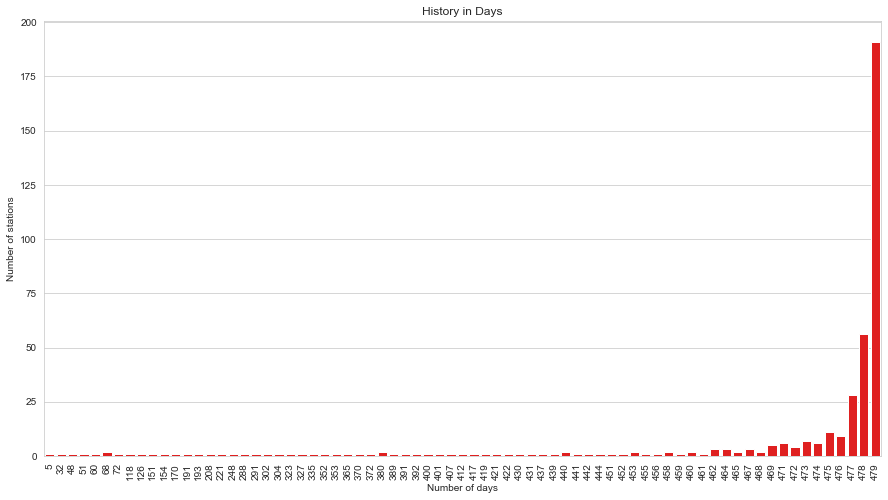

In [38]:
sns.set_style('whitegrid')

plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
plt.title('History in Days')

ax = sns.countplot(x=number_of_days, color='Red')
ax.set(xlabel='Number of days', ylabel='Number of stations')

In [39]:
max(pd.to_datetime(price_data.DATE_CHANGED)) - min(pd.to_datetime(price_data.DATE_CHANGED))

Timedelta('478 days 13:44:00')

Most of the stations have a history over the full range of 479 days or only a few days are missing. There are only few stations having a short history

## Question 2: What is the min, mean, max price for each gasoline type and station weekly (time series graph)

In [40]:
price_data['WEEK'] = price_data['DATE'].map(lambda date: date.isocalendar()[1])
price_data['YEAR'] = price_data['DATE'].map(lambda date: date.isocalendar()[0])
price_data.head()

,STID,E5,E10,DIESEL,DATE_CHANGED,CHANGED,DATE,WEEK,YEAR
366077,00060385-0001-4444-8888-acdc00000001,1549.0,1509.0,1349.0,2014-08-29 15:46:01.000000,63,2014-08-29,35,2014
1065979,00060385-0001-4444-8888-acdc00000001,1559.0,1519.0,1359.0,2014-08-30 08:10:01.000000,21,2014-08-30,35,2014
455544,00060385-0001-4444-8888-acdc00000001,1569.0,1529.0,1359.0,2014-09-01 06:30:01.000000,20,2014-09-01,36,2014
366078,00060385-0001-4444-8888-acdc00000001,1559.0,1519.0,1359.0,2014-09-05 07:02:01.000000,20,2014-09-05,36,2014
366079,00060385-0001-4444-8888-acdc00000001,1559.0,1519.0,1359.0,2014-09-05 09:46:01.000000,63,2014-09-05,36,2014


Sort values by year and week of year and calculate the minimal, maximal and mean price for each week

In [41]:
mean_data = price_data.groupby(['YEAR', 'WEEK'])['DIESEL', 'E5', 'E10'].mean() / 1000
mean_data.columns = ['DIESEL_MEAN', 'E5_MEAN', 'E10_MEAN']
min_data = price_data.groupby(['YEAR', 'WEEK'])['DIESEL', 'E5', 'E10'].min() / 1000
min_data.columns = ['DIESEL_MIN', 'E5_MIN', 'E10_MIN']
max_data = price_data.groupby(['YEAR', 'WEEK'])['DIESEL', 'E5', 'E10'].max() / 1000
max_data.columns = ['DIESEL_MAX', 'E5_MAX', 'E10_MAX']

mean_min_max_data = mean_data.join(min_data)
mean_min_max_data = mean_min_max_data.join(max_data)

mean_min_max_data.head()

DIESEL_MEAN   E5_MEAN  E10_MEAN  DIESEL_MIN  E5_MIN  E10_MIN  \
YEAR WEEK                                                                 
2014 23       1.370311  1.577437  1.537437       1.279   1.489    1.449   
     24       1.386598  1.596587  1.556558       1.259   1.479    1.439   
     25       1.400876  1.611872  1.571881       1.279   1.479    1.439   
     26       1.396966  1.608637  1.568598       1.279   1.499    1.399   
     27       1.389143  1.605565  1.565581       1.279   1.489    1.449   

           DIESEL_MAX  E5_MAX  E10_MAX  
YEAR WEEK                               
2014 23         1.519   1.719    1.679  
     24         1.539   1.759    1.709  
     25         1.549   1.749    1.709  
     26         1.549   1.749    1.709  
     27         1.549   1.749    1.709

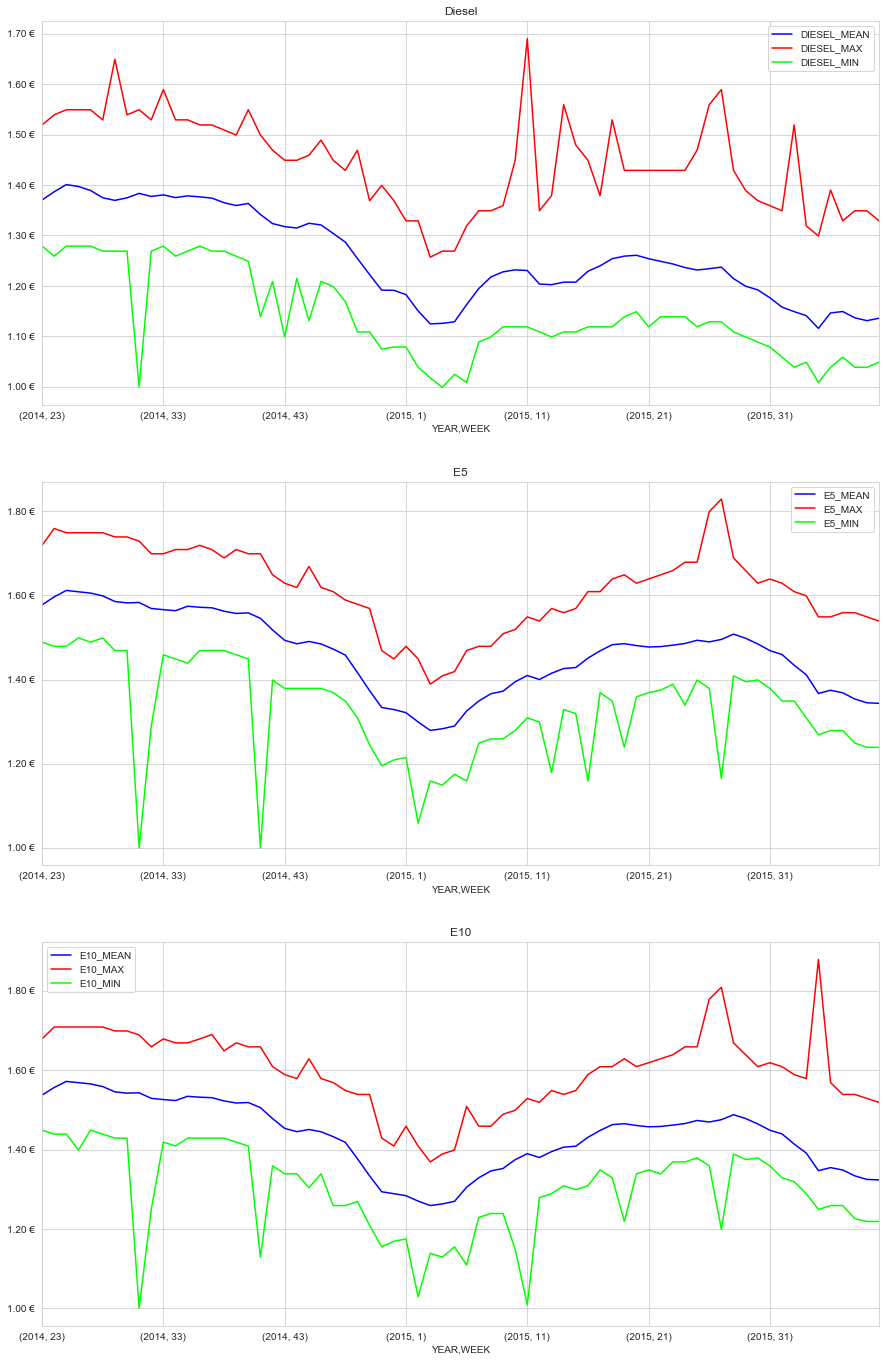

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 24))

mean_min_max_data.plot(y=['DIESEL_MEAN', 'DIESEL_MAX', 'DIESEL_MIN'], use_index=True, colormap='brg', ax=ax1)
ax1.set_title('Diesel')
ax1.yaxis.set_major_formatter(tick.FormatStrFormatter('%1.2f €'))

mean_min_max_data.plot(y=['E5_MEAN', 'E5_MAX', 'E5_MIN'], use_index=True, colormap='brg', ax=ax2)
ax2.set_title('E5')
ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%1.2f €'))

mean_min_max_data.plot(y=['E10_MEAN', 'E10_MAX', 'E10_MIN'], use_index=True, colormap='brg', ax=ax3)
ax3.set_title('E10')
ax3.yaxis.set_major_formatter(tick.FormatStrFormatter('%1.2f €'))

The price fluctuations within a week are about 20 cent. Some weeks contain larger outliers for the maximum and minimum values.

## Question 3: What is cheapest station (in average) and why?

In [43]:
cheapest = price_data.groupby('STID')['DIESEL', 'E5', 'E10'].mean()
cheapest = cheapest.sum(axis=1) / 3
cheapest.sort_values(inplace=True)

In [44]:
cheapest_station = station_data[station_data['STID'] == (cheapest.head(1).index[0])]
print("The cheapest station is " + cheapest_station['NAME'].values[0] + " in " + 
      cheapest_station['STREET'].values[0] + " " + cheapest_station['HOUSE_NUMBER'].values[0] + ", " 
      + cheapest_station['POST_CODE'].values[0] + " " + cheapest_station['PLACE'].values[0])
print("The average price is %1.2f €" %(cheapest.head(1)[0]/1000))

The cheapest station is Winkler-Kaiserslautern in Mainzer Straße 110, 67657 Kaiserslautern
The average price is 1.28 €


In [45]:
print("The average price for the most expensive station is %1.2f €" %(cheapest.tail(1)[0]/1000))

The average price for the most expensive station is 1.49 €


In [46]:
number_of_days[cheapest.head(1).index[0]]

68

The cheapest station is Winkler-Kaiserslautern, but one reason for this might be the small number of days

## Question 4: At which day of a week is the price most likely the cheapest (week profile)

In [47]:
price_data['WEEKDAY'] = pd.to_datetime(price_data['DATE_CHANGED']).apply(pd.datetime.weekday)
weekdays = price_data.groupby(['WEEKDAY'])['DIESEL', 'E5', 'E10'].mean().sum(axis=1) / 3000

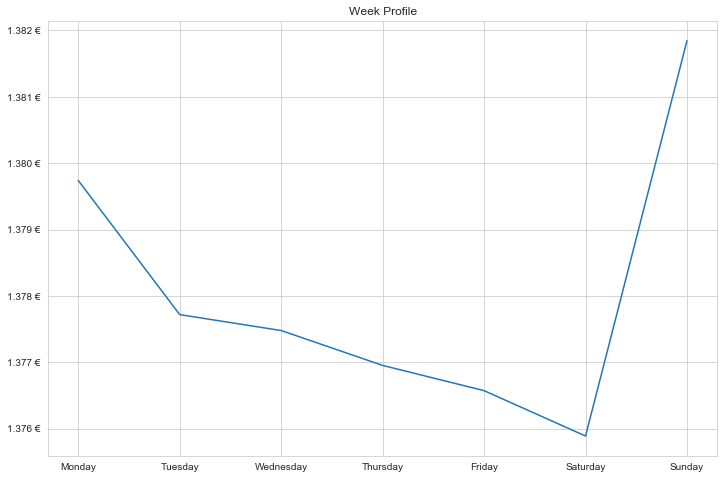

In [48]:
import calendar

plt.figure(figsize=(12,8))
plt.title('Week Profile')
plt.gca().yaxis.set_major_formatter(tick.FormatStrFormatter('%1.3f €'))
plt.plot(calendar.day_name[0:7], weekdays)

The day of the week with the lowest average gasoline price is Saturday, the most expensive day is Sunday. However, the difference between the two days is only less than 1 cent.

## Question 5: At which hour during a day is the price the cheapest in average (hour profile)

In [49]:
price_data['HOUR'] = [pd.to_datetime(x).hour for x in price_data['DATE_CHANGED']]
hours = price_data.groupby(['HOUR'])['DIESEL', 'E5', 'E10'].mean().sum(axis=1) / 3000

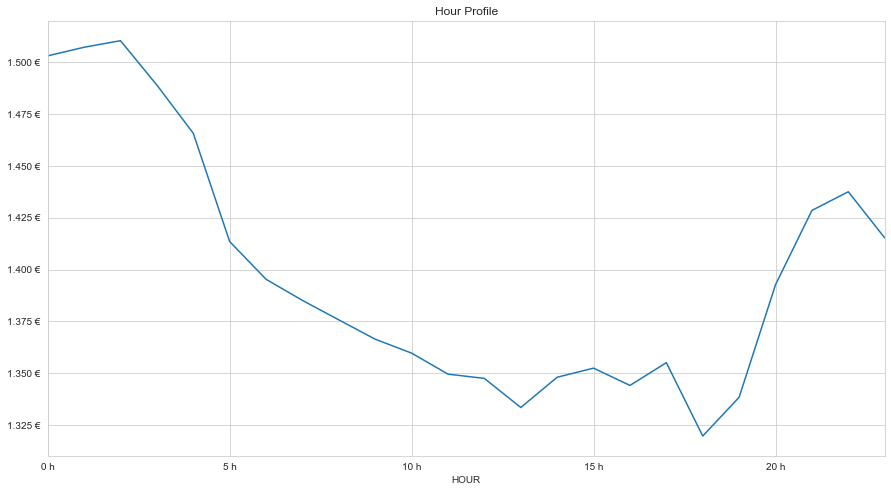

In [50]:
plt.figure(figsize=(12,8))
plt.title('Hour Profile')
plt.gca().yaxis.set_major_formatter(tick.FormatStrFormatter('%1.3f €'))
plt.gca().xaxis.set_major_formatter(tick.FormatStrFormatter('%d h'))
hours.plot(figsize=(15,8))

The time for the cheapest gas price is 6 pm. Between 8 pm and 6 am it's most expensive. There is a difference of nearly 20 cent.

## Question 6: How many different station locations are present in the data (visualize via a map)

In [51]:
import geopandas as gpd

Import map of germany

In [52]:
map_df = gpd.read_file('map/vg2500_bld.shp')

In [53]:
min_lat = min(station_data['LAT'])
max_lat = max(station_data['LAT'])
min_lng = min(station_data['LNG'])
max_lng = max(station_data['LNG'])

coordinates = gpd.GeoDataFrame(geometry=gpd.points_from_xy(station_data['LNG'], station_data['LAT']))

Plot the coordinates of the different stations as red dots and add some bigger cities to the map

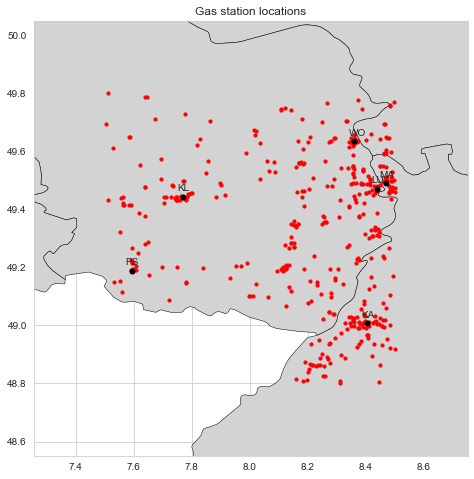

In [54]:
ax = map_df.plot(color = 'lightgrey', linewidth = 0.5, edgecolor = 'black', figsize=(12,8))

ax.set_title("Gas station locations")
ax.set_xlim(min_lng - 0.25, max_lng + 0.25)
ax.set_ylim(min_lat - 0.25, max_lat + 0.25)

cities = {
    'KL': 'Kaiserslautern',
    'MA': 'Mannheim',
    'LU': 'Ludwigshafen',
    'KA': 'Karlsruhe',
    'PS': 'Pirmasens',
    'WO': 'Worms'
}

geolocator = Nominatim(user_agent='cities', timeout=10) 
for abb, name in cities.items():
    location = geolocator.geocode(name)
    ax.text(location.longitude - 0.02, location.latitude + 0.02, abb, fontsize=10)
    ax.plot(location.longitude, location.latitude, 'ok', color='black', markersize=5)

geo_df = gpd.GeoDataFrame(coordinates, crs = {'init': 'epsg:4326'}, geometry = coordinates['geometry'])
geo_df.plot(markersize = 10, ax = ax, color='red')

The petrol stations are located in a square of about one degree longitude and one degree latitude. Most of the stations are located in Rheinland-Pfalz, some are in Hessen and Baden-Würtemberg. Most of the stations are located in large cities.

In [55]:
unique_places = station_data['PLACE'].unique()
print("The data set contains stations from %d different cities" %len(unique_places))

The data set contains stations from 146 different cities


## Question 7: What is the gas station which has most price data points, choose one and draw the time series for all 3 gasonline types

In [56]:
number_of_datapoints = price_data.groupby(['STID']).size()
most_data_points = number_of_datapoints[number_of_datapoints == max(number_of_datapoints)] 

data_points = price_data[price_data['STID'] == most_data_points.index[0]]

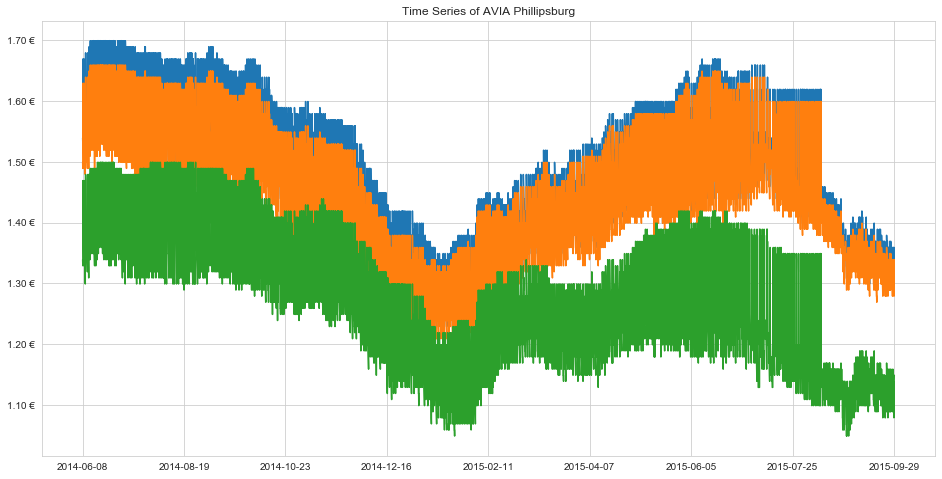

In [57]:
plt.figure(figsize=(16,8))

plt.plot(data_points['E5'].values / 1000)
plt.plot(data_points['E10'].values / 1000)
plt.plot(data_points['DIESEL'].values / 1000)

date_list = list(data_points['DATE_CHANGED'].apply(lambda x: x.split(" ")[0]))
indexs = range(len(date_list) - 1)[::int(len(date_list) / 8)]
ticks = date_list[0:len(date_list) - 1:int(len(date_list) / 8)]
plt.xticks(indexs, ticks)

plt.title('Time Series of ' + station_data[station_data['STID'] == most_data_points.index[0]]['NAME'].values[0])
plt.gca().yaxis.set_major_formatter(tick.FormatStrFormatter('%1.2f €'))

In [58]:
station_data[station_data['STID'] == most_data_points.index[0]]['NAME'].values[0]

'AVIA Phillipsburg'

The graph shows the price development of the petrol station Avia Phillipsburg. 
Until August 2015 the prices oscillate by up to 20 cent, afterwards only up to 5 cent. 
One reason for this could be changed opening hours.

## Question 8: At which hour during a day do we have the most price changes

In [59]:
# functions returns 1 if there is a price change in e5, e10 and/or diesel, returns 0 if there is no change
# unit test at end of file

def price_changes(df):
    diesel_mask = 3
    diesel_changed = 1

    e5_mask = 12
    e5_changed = 4

    e10_mask = 48
    e10_changed = 16
        
    change = 0
    
    if int(df['CHANGED']) & diesel_mask == diesel_changed:
        change = 1
    elif int(df['CHANGED']) & e5_mask == e5_changed:
        change = 1
    elif int(df['CHANGED']) & e10_mask == e10_changed:
        change = 1
        
    return change

In [60]:
price_data['PRICE_CHANGE'] = price_data.apply(price_changes, axis=1)

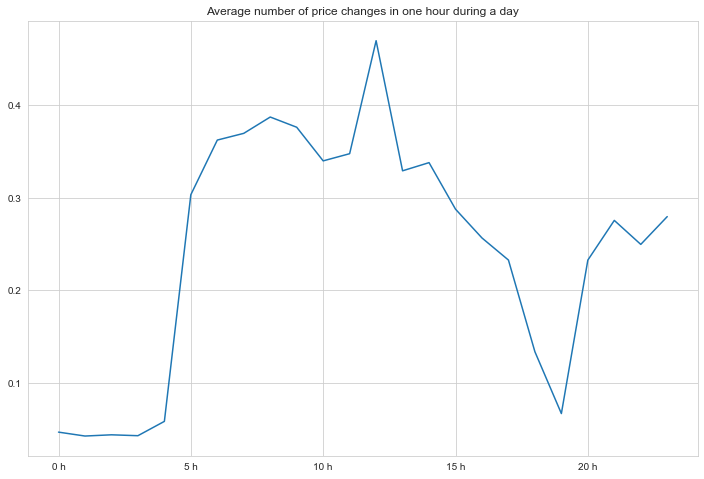

In [61]:
number_of_price_changes = price_data.groupby('HOUR')['PRICE_CHANGE'].sum()
number_of_price_changes = number_of_price_changes / (len(unique_stids_price) * number_of_days.mean())

plt.figure(figsize=(12,8))
plt.title('Average number of price changes in one hour during a day')
plt.gca().xaxis.set_major_formatter(tick.FormatStrFormatter('%d h'))
plt.plot(number_of_price_changes)

Most price changes take place around midday. At night between midnight and 4 am there are almost no price changes.

In [62]:
number_of_price_changes

HOUR
0     0.046866
1     0.042644
2     0.043968
3     0.043003
4     0.058489
5     0.303447
6     0.362476
7     0.369745
8     0.387372
9     0.376334
10    0.339993
11    0.347752
12    0.469873
13    0.329259
14    0.338094
15    0.287801
16    0.256692
17    0.232817
18    0.133732
19    0.066932
20    0.232756
21    0.275665
22    0.249732
23    0.279766
Name: PRICE_CHANGE, dtype: float64

## Question 9: Select 20 gas stations having the longest time history and visualize the average price per month. Use heatmap and only the prices between 12:00-13:00 of e10 and diesel.

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


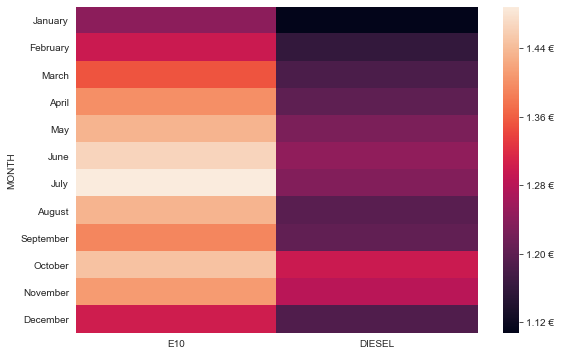

In [63]:
longest_history = number_of_days.sort_values().tail(20)
longest_history = price_data[price_data['STID'].isin(longest_history.index)]
between_12_13 = longest_history[longest_history['HOUR'] == 12]
between_12_13['MONTH'] = [pd.to_datetime(x).month for x in between_12_13['DATE_CHANGED']]

month = between_12_13.groupby('MONTH')["E10", "DIESEL"].mean() / 1000

plt.figure(figsize=(9,6))
sns.heatmap(month, cbar_kws={'format': '%1.2f €'}, yticklabels=calendar.month_name[1:13])

For both e10 and diesel the price is higher in the summer months than in the winter months.

## Question 10: Describe a possible business potential in € for the customer (textual description in the ipyhton file). Define the constraints of the business case 5 lines, the answer max 15 lines (high level summary)

#### The results could help a car fleet save on fuel. The following points could help:
- They could refuel on days of the week when the price is cheapest. However, it has been shown that the day of the week has no great influence on the price (~ 1.37€ - 1.38€)
- In contrast, the time has a big influence on the price (~ 1.30€ - 1.50€).  The cheapest time is in the evening at 6. In any case you should avoid filling up at night.
- There is also a large price difference between the individual petrol stations (in average 1.28€ - 1.49€). One could determine the cheapest filling station for different zones 

#### There are different constraints in those cases: 
- A cheap petrol station must be nearby or the loss due to a longer journey must be compensated by a cheaper petrol price.
- The tank filling must still be sufficient, in order to be able to drive to the next cheap gas station
- For various reasons it may not always be possible to refuel at the most cheapest hour

## Unit Tests

In [64]:
import unittest

In [65]:
class TestFunctions(unittest.TestCase):
  
    def test_calculate_price(self): 
        test_data_frame = pd.DataFrame(np.array([[1, 1, 1.0, 5], 
                                                 [2, 1, 1.2, 12],
                                                 [2, 2, 1.4, 11 ],
                                                 [2, 2, 1.4, 48 ]]), 
                                       columns=['STID', 'STID_SHIFT', 'DIESEL', 'CHANGED'])
        test_data_frame_2 = pd.DataFrame(np.array([[1, 1, 1.0, 5], 
                                                  [2, 1, 1.2, 12],
                                                  [2, 2, 1.4, 11 ],
                                                  [2, 2, 1.4, 48 ]]), 
                                       columns=['STID', 'STID_SHIFT', 'E10', 'CHANGED'])
        test_data_frame_3 = pd.DataFrame(np.array([[1, 1, 1.0, 5], 
                                                   [2, 1, 1.2, 12],
                                                   [2, 2, 1.4, 11 ],
                                                   [2, 2, 1.4, 48 ]]), 
                                       columns=['STID', 'STID_SHIFT', 'E5', 'CHANGED']) 
        
        
        pd.testing.assert_series_equal(test_data_frame.apply(calculate_price, gasoline_type='diesel', axis=1), 
                                       pd.Series([1.0, 1.2, 1.4, np.NaN]))
        pd.testing.assert_series_equal(test_data_frame_2.apply(calculate_price, gasoline_type='e10', axis=1), 
                                       pd.Series([np.NaN, 1.2, np.NaN, 1.4]))
        pd.testing.assert_series_equal(test_data_frame_3.apply(calculate_price, gasoline_type='e5', axis=1), 
                                       pd.Series([1.0, 1.2, -1, np.NaN]))
    
                
    def test_get_address(self):
        # SSC of TU Kaiserslautern and Statium Betzenberg in Kaiserslautern
        coordinates = pd.DataFrame(np.array([[np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, 49.424063, 7.754470], 
                                           [np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, 49.434199, 7.776775]]),
                        columns=['STREET', 'HOUSE_NUMBER', 'POST_CODE', 'PLACE', 'PUBLIC_HOLIDAY_IDENTIFIER', 'LAT', 'LNG']) 
                                   
        pd.testing.assert_frame_equal(coordinates.apply(get_address, axis=1),
                                     pd.DataFrame(np.array([['Gottlieb-Daimler-Straße', 47, 67663, 'Kaiserslautern', 'Rheinland-Pfalz', 49.424063, 7.754470],
                                                           ['Fritz-Walter-Straße', 1, 67663, 'Kaiserslautern', 'Rheinland-Pfalz', 49.434199, 7.776775]]),
                                        columns=['STREET', 'HOUSE_NUMBER', 'POST_CODE', 'PLACE', 'PUBLIC_HOLIDAY_IDENTIFIER', 'LAT', 'LNG']))
        
        
    def test_price_changes(self):
        test_data_frame = pd.DataFrame(np.array([[1],[4],[16], [0], [21], [12]]), columns=['CHANGED'])
        
        pd.testing.assert_series_equal(test_data_frame.apply(price_changes, axis=1), 
                                      pd.Series([1, 1, 1, 0, 1, 0]))
    
    
unittest.main(argv=[''], verbosity=2, exit=False)
        

test_calculate_price (__main__.TestFunctions) ... ok
test_get_address (__main__.TestFunctions) ... FAIL
test_price_changes (__main__.TestFunctions) ... ok

FAIL: test_get_address (__main__.TestFunctions)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-65-6fd11333e5c9>", line 38, in test_get_address
    columns=['STREET', 'HOUSE_NUMBER', 'POST_CODE', 'PLACE', 'PUBLIC_HOLIDAY_IDENTIFIER', 'LAT', 'LNG']))
  File "D:\Software\Anaconda\lib\site-packages\pandas\util\testing.py", line 1502, in assert_frame_equal
    obj='DataFrame.iloc[:, {idx}]'.format(idx=i))
  File "D:\Software\Anaconda\lib\site-packages\pandas\util\testing.py", line 1336, in assert_series_equal
    obj='{obj}'.format(obj=obj))
  File "pandas/_libs/testing.pyx", line 66, in pandas._libs.testing.assert_almost_equal
  File "pandas/_libs/testing.pyx", line 180, in pandas._libs.testing.assert_almost_equal
  File "D:\Software\Anaconda\lib\site-pack

The second test fails because we couldn't find a house number for the ssc. As already written above, geopy cannot find all house numbers for the given coordinates.

Save data for exercise_2

In [66]:
price_data.to_csv('ex1_out.csv', sep=';')